# Topic Segmentation and Visualization of Online Lectures

### Jupyter settings

In [1]:
# Print out every value 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Imports

In [2]:
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
from wordcloud import WordCloud
import json
from pathlib import Path
import requests
import xml.etree.ElementTree as ET

%matplotlib inline

In [3]:
import spacy
import gensim.matutils
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim.models import LsiModel
from gensim.models import nmf

# Data Preparation

This Notebook reads the transkript files and prepares the data.   
This consists of :
* extracting the spoken text + metadata from the files
* tokenization (while removing stopwords etc.)
* vektorization

### Reading the data + Tokenization 

Tokenization and preprocessing is accomplished with spacy, because it has a simple way for lemmatization and POS.  
Some additional stopwords are added, because they are created by the transkription and are possible not necessary.  

In [4]:
spacy.require_gpu()

# define space nlp with just the tagger (includes lemmatizer)
nlp_spacy = spacy.load('en_core_web_trf')


# adding aditional stop words
additional_stopwords = {'#cough', '#sneeze', '#bs', '#breath', '#ahm', 'deu','sabine','sandra','eva','dominik','katrin','girl'
                        'tomorrow', 'yesterday','johannes', 'today'}
nlp_spacy.Defaults.stop_words |= additional_stopwords
nlp_spacy.Defaults.stop_words |= set(string.punctuation)


# synonyms
synonyms = {
    "ja": "yes"
}

def replace_with_syn(token):
    if token in synonyms:
        return synonyms[token]
    return token

#tokenization and pre-processing with spacy
def tokenize(text):
    spacy_doc = nlp_spacy(filter_special_tokens(text))
    # append the lemma of the tokes if they are a noun
    tokens = [token.lemma_ for token in spacy_doc if token.pos_ in ['NOUN', 'PROPN', 'VERB']]
    # remove stop-words and replace with synonym if there exists one
    tokens = [replace_with_syn(token) for token in tokens if token.lower() not in nlp_spacy.Defaults.stop_words]
    #combine tokens which belong together ( "x. ray","c. arm" ....)
    tokens = combine_tokens(tokens)
    #filter tokens which are too short or too long
    tokens = [token for token in tokens if len(token)>2 and len(token)<25]
    return tokens

#this method is called in the tokenize method
#to filter special tokens of the transkript like "#ahm", "#cough"
def filter_special_tokens(text):
    tokens = re.split(' ', text)
    #filter "#ahm".... , wrong spoken words and "ja~deu"
    tokens = [extract_different_lang(token) for token in tokens if "#" not in token and "*" not in token]
    return " ".join(tokens)


def extract_different_lang(word):
    if "~" in word:
        return word[:word.index("~")]
    return word


def combine_tokens(tokens):
    if "c." not in tokens and "x." not in tokens and "s." not in tokens:
        return tokens
    i = 0
    while(i<len(tokens)-1):
        #checks if "c." and "arm" are 2 seperate tokens
        if tokens[i] == "c.":
            if tokens[i+1] == "arm":
                tokens[i] = "c.arm"
                tokens.pop(i+1)
        #checks for "x." and "ray"
        elif tokens[i] == "x.":
            if tokens[i+1] == "ray":
                tokens[i] = "x.ray"
                tokens.pop(i+1)
        #checks for "s","v","d"
        elif tokens[i] == "s.":
            if i+2 >= len(tokens):
                i=i+1
                continue
            if tokens[i+1] == "v." and tokens[i+2] == "d.":
                tokens[i] = "s.v.d."
                tokens.pop(i+2)
                tokens.pop(i+1)
        i = i+1
    return tokens
        

def extract_info_from_metadata(meta):
    regex = r"(\d*)-(.*)_(\d*)_(\d*)"
    parts = re.search(regex, meta)
    if not parts:
        return meta, "", "", ""
    date = parts.group(1)
    lecture = parts.group(2)   
    time_from = extract_seconds(parts.group(3))
    time_to = extract_seconds(parts.group(4))
    return lecture, date, time_from, time_to
 
def extract_seconds(timestamp):
    return float(timestamp[:-3] + "." + timestamp[-3:])

True

Here are multiple functions, which apply the tokenize function to the given document. It return a List of Tokens, which are then transformed into a DataFrame

In [5]:
def convert_doc_to_dataframe(file, keep_meta=True):
   # check each line and extract the text and time out of it
    docs = []
    for row in file:
        # extract metadata out of the line
        if ".wav" in row and keep_meta:
            index = row.index(".wav")+4
            meta = row[:index]
            row = row[index:]
            lecture, date, time_from, time_to = extract_info_from_metadata(meta)
            tokens = tokenize(row)
            if tokens:
                docs.append({'Lecture': lecture, 'Date': date,'Time_from': time_from, 
                     'Time_to': time_to, 'Text': row.replace("\n",""), 'Text_tokens': tokens})
        
        #only keep the tokens without any other data 
        else:
            index = row.index(".wav")+4 if ".wav" in row else 0
            tokens = tokenize(row[index:])
            if tokens:
                docs.append({'Text_tokens': filter_special_tokens(tokens.replace("\n","")), 'Text': row [index:].replace("\n","")})
    return pd.DataFrame(docs)

def convert_doc_to_dataframe_with_merge(file, num = 10):
    """this method doesnt extract metadata like the method without merge does
    len(file) doesnt exist, so we use i to count the lines"""
    docs=[]
    currentPart = ""
    i = 1
    for row in f:
        index = row.index(".wav")+4 if ".wav" in row else 0
        currentPart = currentPart + " " + row[index:]
        if i % num == 0:
            i = 1
            tokenized_text = tokenize(currentPart)
            if tokenized_text:
                docs.append({"Text":filter_special_tokens(currentPart.replace("\n","")),"Text_tokens":tokenized_text})
            currentPart = ""
            continue
        i = i+1
    #if len(file)%num != null, there will be a part left 
    if currentPart != "":
        tokenized_text = tokenize(currentPart)
        if tokenized_text:
            docs.append({"Text":filter_special_tokens(currentPart.replace("\n","")),"Text_tokens":tokenized_text})
    
    return pd.DataFrame(docs)


def convert_lecture_to_tokens(file):
    text = ""
    for row in file:
        index = row.index(".wav")+4 if ".wav" in row else 0
        text = text + row[index:]
    return tokenize(text), text.replace("\n","")

Different extractions of Text Size:  
* One Lecture with one line as each doc
* One Lecture with ~10 lines as each doc
* One Lecture as each doc with all the lectures of the same topic

In [6]:
#Get all Filenames of the IMIP-Lectures
#the replace("\\","/") is necessary for windows
path  = 'LMELectures/trl'
files = []
for r,d,f in os.walk(path):
    for file in f:
        if 'IMIP' in file:
            files.append(os.path.join(r,file).replace("\\","/"))
            
train_count=round(len(files)*0.8)
test_count=len(files)-train_count
column_list = ['Lecture','Date','Time_from','Time_to','Text','Text_tokens']

In [7]:
%%time
""" Convert a single file into a DataFrame """
# read a file and create a dataFrame ( dev and test) out of it
speech_df_single_lecture = pd.DataFrame(columns=column_list)
speech_df_single_lecture_test = pd.DataFrame(columns=column_list)


for i in range(len(files)):
    f = open(files[i],"r")
    df = pd.DataFrame(convert_doc_to_dataframe(f))
    df['File_name']= files[i].replace(".wav",'').replace(path+'/','').replace(".trl",'')
    if i < train_count:
        speech_df_single_lecture = speech_df_single_lecture.append(df)
    else:
        speech_df_single_lecture_test = speech_df_single_lecture_test.append(df)

        
speech_df_single_merged = speech_df_single_lecture.append(speech_df_single_lecture_test)
    
speech_df_single_lecture['Text_tokens']
speech_df_single_lecture_test['Text_tokens']

Wall time: 3min 5s


0             [morning, guest, speaker, student, attend]
1           [mean, invite, want, invite, people, expect]
2                                       [people, attend]
3                                             [semester]
4                                          [topic, look]
                             ...                        
503                                   [time, rest, life]
504          [hope, enjoy, bit, enjoy, lot, like, topic]
505                                               [hope]
506    [area, image, processing, look, supervise, sup...
507                                              [thank]
Name: Text_tokens, Length: 1720, dtype: object

In [8]:
speech_df_single_lecture.head()

,Lecture,Date,Time_from,Time_to,Text,Text_tokens,File_name
0,Hornegger-IMIP01,20090427,1.48,3.23,so welcome to the,[welcome],20090427-Hornegger-IMIP01
1,Hornegger-IMIP01,20090427,4.36,25.30,first lecture on interventional image process...,"[lecture, image, processing, winter, semester,...",20090427-Hornegger-IMIP01
2,Hornegger-IMIP01,20090427,25.96,35.55,the summer semester and i think eva gave a ve...,"[summer, semester, think, introduction, week, ...",20090427-Hornegger-IMIP01
3,Hornegger-IMIP01,20090427,36.24,52.98,and intervention is a completely different ca...,"[intervention, category, diagnostic, intervent...",20090427-Hornegger-IMIP01
4,Hornegger-IMIP01,20090427,53.48,62.85,so you always have to keep the picture in min...,"[picture, mind, patient, blood, equipment, mon...",20090427-Hornegger-IMIP01


In [9]:
%%time
""" Convert a single file (with merge of lines) into a DataFrame"""
# read a file and create a dataFrame out of it
speech_df_merged_lines = pd.DataFrame(columns=column_list)
speech_df_merged_lines_test = pd.DataFrame(columns=column_list)
line_merge_count = 10

for i in range(len(files)):
    f = open(files[i],"r")
    df = pd.DataFrame(convert_doc_to_dataframe_with_merge(f,line_merge_count))
    df['File_name']= files[i].replace(".wav",'').replace(path+'/','').replace(".trl",'')
    if i < train_count:
        speech_df_merged_lines = speech_df_merged_lines.append(df)
    else:
        speech_df_merged_lines_test = speech_df_merged_lines_test.append(df)

speech_df_merged_lines['Text_tokens']
speech_df_merged_lines_test['Text_tokens']

Wall time: 44.9 s


0     [morning, guest, speaker, student, attend, mea...
1     [add, page, come, mind, map, tuesday, session,...
2     [image, coordinate, system, coordinate, system...
3     [depend, displacement, vector, field, observat...
4     [similarity, thing, classifier, reduce, proble...
                            ...                        
73    [component, component, topic, exam, know, forg...
74    [transform, image, base, term, require, transf...
75    [week, term, use, knowledge, density, apply, u...
76    [question, question, comment, let, end, semest...
77    [area, image, processing, look, supervise, sup...
Name: Text_tokens, Length: 226, dtype: object

In [10]:
%%time
""" Convert each online lecture into a DataFrame """
#Get the tokens for each lecture
docs = []
docs_test = []
for i in range(len(files)):
    file = open(files[i], "r")
    tokens,texts = convert_lecture_to_tokens(file)
    data = {'File_name':files[i].replace(".wav",'').replace(path+'/','').replace(".trl",''),
            'Text_tokens':tokens, 
            'Text':filter_special_tokens(texts).replace("\n","")}
    if i < train_count:
        docs.append(data)
    else:
        docs_test.append(data)
        
speech_df = pd.DataFrame(docs)
speech_df_test = pd.DataFrame(docs_test)

Wall time: 40.2 s


In [11]:
speech_df['Text_tokens']
speech_df['Text']

0     [welcome, lecture, image, processing, winter, ...
1     [miss, professor, want, tone, pay, tell, minut...
2     [look, know, screw, system, video, look, navig...
3     [start, time, leave, image, processing, image,...
4     [welcome, tuesday, session, discuss, sound, so...
5     [morning, image, processing, image, processing...
6     [welcome, monday, session, minute, let, minute...
7     [morning, tuesday, morning, overview, lecture,...
8     [mac, look, let, summarize, mind, map, finalis...
9     [welcome, monday, session, minute, image, proc...
10    [morning, tuesday, morning, session, talk, cat...
11    [morning, office, trip, bonn, alex, replace, t...
12    [afternoon, session, talk, image, registration...
13    [morning, tuesday, session, minute, minute, re...
Name: Text_tokens, dtype: object

0      so welcome to the first lecture on interventi...
1      i'm sorry i missed that confused professor if...
2      looks good i don't know something screwed the...
3      today we have to start on time because i have...
4      so welcome to the tuesday session we are curr...
5      so good morning everybody medical image proce...
6      so welcome welcome to the monday session fort...
7      so good morning tuesday morning as usual we w...
8      so to it's little different than what i have ...
9      okay so welcome to the monday session just fo...
10     so good morning everybody tuesday morning ses...
11     welcome good morning everybody i'm sorry that...
12     welcome to the afternoon session we are curre...
13     so good morning everybody tuesday session nin...
Name: Text, dtype: object

### Vektorization

In this part the Tf and Tf-idf vectors are created for each document

In [12]:
#create a global dictionary with all tokens from the lectures
dataset = corpora.Dictionary()
dataset.add_documents(speech_df['Text_tokens'].tolist())
dataset.add_documents(speech_df_test['Text_tokens'].tolist())
#dataset.filter_extremes(no_below=0,no_above=0.7)

def prep_for_model(dataframe):
    #create the tfidf vectors
    corpus = [dataset.doc2bow(text) for text in dataframe['Text_tokens'].tolist()]
    tfidf_vect = TfidfModel(corpus)
    return corpus,tfidf_vect

# Latent Semantic Analysis/Indexing 

Gensim is a popilar tool for topic modeling. It provides a variety of different algorithms. The one we will use is the LsiModel.

In [13]:
def create_lsi_model(dataframe,topics=10):
    corpus,tfidf_vect = prep_for_model(dataframe)
    model = LsiModel(tfidf_vect[corpus], id2word=dataset, num_topics=topics)
    #model_tf = LsiModel(corpus,id2word=dataset,num_topics=topics)
    return model

In [14]:
#This function prints the top 10 words for each topic from a given model 
def write_model_to_file(model,filename):
    output = {}
    for i in range(0, model.num_topics):
        keywords = ''
        keywords_dist = model.show_topic(i)
        for word in keywords_dist:
            keywords += word[0] + ' '
        output[i] = keywords
    json.dump(output, open( '{0}.json'.format(filename), 'w' ) )

### Number of Topics

One way to evaluate a model is by its coherence.  
We try different topic numbers to find the optimal number of topics the model should have.  

In [15]:
def evaluate_graph(dataframe,min_topic_num=5,max_topic_num=20, coherence_metric="c_v", model_type ="lsi"):
    model_list = []
    coherence_values = []
    #create the corpus for the model 
    corpus,tfidf_vect = prep_for_model(dataframe)
    
    for topics_num in range(min_topic_num,max_topic_num + 1):
        #Create the LsiModels with increasing number of Topics\
        if model_type == "nmf":
            model = nmf.Nmf(tfidf_vect[corpus], id2word=dataset, num_topics=topics_num)
        else:
            model = LsiModel(tfidf_vect[corpus], id2word=dataset, num_topics=topics_num)
        model_list.append(model)
        
        topics_model= [[word for word, prob in topic] for topicid, topic in model.show_topics(formatted=False)]
        #Create the CoherenceModel and evaluate its score
        coherence_model = CoherenceModel(topics=topics_model, texts=dataframe['Text_tokens'].tolist()
                                         ,dictionary=dataset,coherence=coherence_metric,
                                        window_size=30)
        coherence_values.append(coherence_model.get_coherence())
        
    # Show graph
    x = range(min_topic_num, max_topic_num + 1)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("c"), loc='best')
    plt.show()
    return model_list, coherence_values, corpus

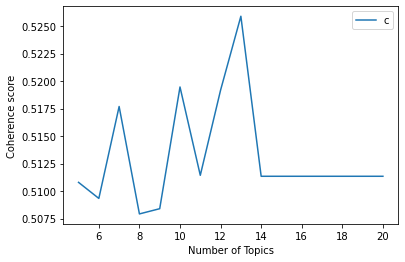

Wall time: 7min 38s


In [16]:
%%time
#Evaluation of the 1 doc equals 1 lecture dataframe
model_list, coherence_values , used_corpus = evaluate_graph(speech_df,min_topic_num=5,max_topic_num=20)

In [17]:
print(coherence_values)

[0.5107892706228582, 0.5093296598215982, 0.5176847352145868, 0.5079208757103758, 0.5083952694742365, 0.5194589650568923, 0.5114303853479149, 0.5191714755187865, 0.5258888440663316, 0.5113426951467565, 0.5113426951467566, 0.5113426951467566, 0.5113426951467566, 0.5113426951467565, 0.5113426951467566, 0.5113426951467565]


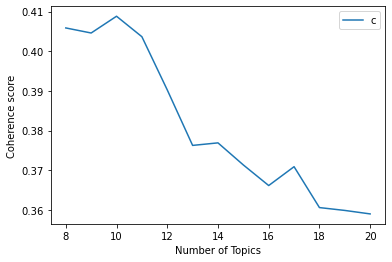

In [18]:
#Evaluation of the 1 doc equals 10 lines of a lecture dataframe
model_list_merged, coherence_values_merged, corpus_used_merged = evaluate_graph(speech_df_merged_lines,min_topic_num=8,max_topic_num=20)

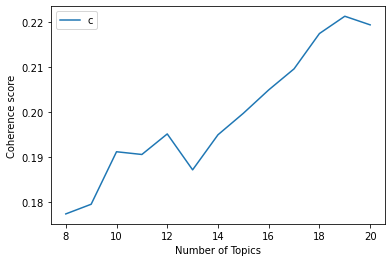

In [19]:
#Evaluation of 1 doc equals 1 line of a lecture 
model_list_single, coherence_values_single, cp_single = evaluate_graph(speech_df_single_lecture,min_topic_num=8,max_topic_num=20)

In [20]:
#get the best model from the document=lecture models
index_value = max(coherence_values)
best_model_index = coherence_values.index(index_value)
best_model = model_list[best_model_index]

best_model.show_topics()

[(0,
  '0.219*"derivative" + 0.210*"rank" + 0.157*"function" + 0.145*"aneurysma" + 0.125*"quaternion" + 0.122*"euler" + 0.122*"column" + 0.116*"epsilon" + 0.114*"coordinate" + 0.113*"endoscope"'),
 (1,
  '0.479*"derivative" + 0.250*"euler" + 0.201*"prime" + 0.197*"function" + 0.179*"epsilon" + -0.145*"aneurysma" + -0.144*"rank" + 0.130*"gradient" + 0.127*"integral" + 0.120*"regard"'),
 (2,
  '0.238*"rank" + 0.207*"glue" + -0.204*"interpolation" + 0.191*"aneurysma" + -0.186*"endoscope" + -0.165*"ray" + 0.162*"column" + -0.152*"surface" + 0.143*"quaternion" + -0.121*"catheter"'),
 (3,
  '-0.276*"catheter" + -0.244*"ellipse" + 0.184*"endoscope" + -0.173*"discriminant" + -0.149*"aneurysma" + -0.128*"interpretation" + 0.125*"interpolation" + 0.124*"rank" + -0.121*"muscle" + 0.119*"ray"'),
 (4,
  '0.379*"aneurysma" + -0.248*"discriminant" + 0.170*"glue" + -0.162*"ellipse" + -0.159*"coefficient" + -0.138*"frame" + -0.131*"circle" + -0.129*"conic" + -0.127*"eigenvector" + -0.124*"probe"'),
 (5

### Visualization

The following part tries to create wordcloud out of the topics.  
The problem with LSI is, that some values can be negative, which results in errors during creation of wordcloud-topics

In [21]:
def topic_word_cloud(model,num_topic, max_word_count=10):
    wc = WordCloud(width=200, height=100, background_color="white", max_words=max_word_count) 
    # Generierung der Wordcloud
    data = dict(model.show_topic(num_topic,max_word_count))
    wc.generate_from_frequencies(data)
    
    # Plot
    fig=plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [22]:
#for i in range(best_model.num_topics):
#    print("Topic %d" % i)
#    try:
#        topic_word_cloud(best_model,i,10)
#    except OSError:
#        continue

### Usage on new documents

We use the "best_model" and use it on a new document, which it hasn't seen yet

In [23]:
def apply_dataframe_to_model(model,used_corpus,dataframe):
    new_corpus = [dataset.doc2bow(dataframe['Text_tokens'])]
    #we use a tfidf vectorizer based on the corpus for the training model
    tfidf_vectorizer = TfidfModel(used_corpus)
    tfidf_vector= tfidf_vectorizer[new_corpus]
    return model[tfidf_vector]

In [24]:
vector = apply_dataframe_to_model(best_model,used_corpus = used_corpus, dataframe= speech_df_test.iloc[0])
for distrib in vector:
    print(distrib)

[(0, 0.3547629055881759), (1, 0.3468165241761819), (2, -0.038143206004774256), (3, 0.01011238452228026), (4, 0.04549660884760733), (5, 0.04317262031639631), (6, 0.028741144218549716), (7, 0.054251716169606994), (8, -0.06374488264450204), (9, -0.06459446166854044), (10, 0.26402352378585925), (11, -0.07199309677558959), (12, -0.031262399739419224)]


# Non-Negative Matrix Factorization

### Number of Topics

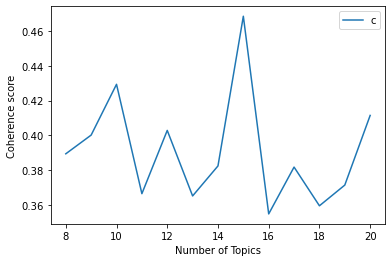

Wall time: 6min 54s


In [25]:
%%time
#Evaluation of the 1 doc equals 1 lecture dataframe
model_list_nmf, coherence_values_nmf , used_corpus_nmf = evaluate_graph(speech_df,min_topic_num=8,max_topic_num=20,model_type="nmf")

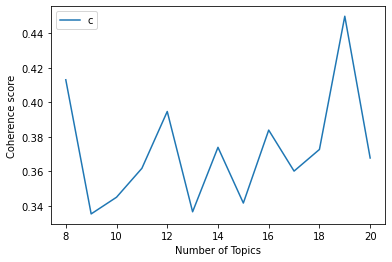

In [26]:
#Evaluation of the 1 doc equals 10 lines of a lecture dataframe
model_list_merged_nmf, coherence_values_merged_nmf, corpus_used_merged_nmf = evaluate_graph(speech_df_merged_lines,min_topic_num=8,max_topic_num=20,model_type="nmf")

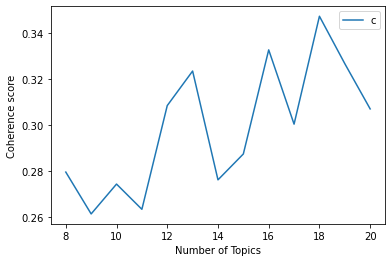

In [27]:
#Evaluation of 1 doc equals 1 line of a lecture 
model_list_single_nmf, coherence_values_single_nmf, cp_single_nmf = evaluate_graph(speech_df_single_lecture,min_topic_num=8,max_topic_num=20,model_type="nmf")

In [28]:
index_value = max(coherence_values_nmf)
best_model_index = coherence_values_nmf.index(index_value)
best_model = model_list_nmf[best_model_index]

best_model.show_topics()

[(5,
  '0.025*"epsilon" + 0.020*"function" + 0.014*"interpolation" + 0.012*"phi" + 0.011*"euler" + 0.010*"filter" + 0.010*"viewing" + 0.010*"corrupt" + 0.009*"brainer" + 0.009*"c.arm"'),
 (2,
  '0.048*"derivative" + 0.024*"function" + 0.023*"euler" + 0.021*"prime" + 0.014*"gradient" + 0.013*"integral" + 0.013*"regard" + 0.013*"epsilon" + 0.012*"derive" + 0.011*"eta"'),
 (3,
  '0.018*"probe" + 0.014*"rank" + 0.014*"coordinate" + 0.013*"lambda" + 0.013*"surgery" + 0.012*"frame" + 0.010*"marker" + 0.009*"floor" + 0.008*"stomach" + 0.008*"journal"'),
 (9,
  '0.026*"scanner" + 0.021*"regularizer" + 0.019*"registration" + 0.018*"scan" + 0.017*"spect" + 0.014*"ellipse" + 0.013*"derivative" + 0.010*"pet" + 0.010*"kidney" + 0.010*"pair"'),
 (1,
  '0.028*"rank" + 0.018*"sigma" + 0.015*"column" + 0.012*"pose" + 0.012*"phi" + 0.012*"unit" + 0.012*"decomposition" + 0.011*"recipe" + 0.010*"matrix" + 0.010*"entry"'),
 (11,
  '0.057*"glue" + 0.025*"column" + 0.022*"scaling" + 0.019*"quaternion" + 0.01

### Visualization 

NMF has only positive values, which means we can create wordclouds out of it

Topic 0


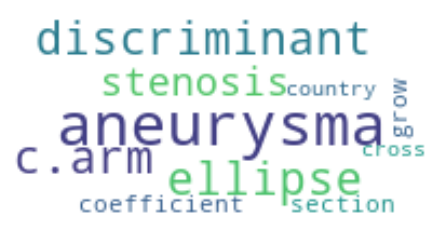

Topic 1


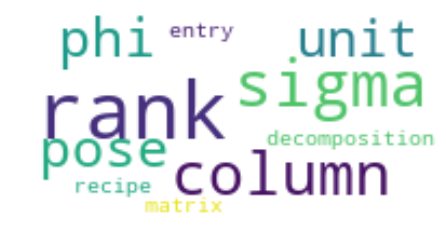

Topic 2


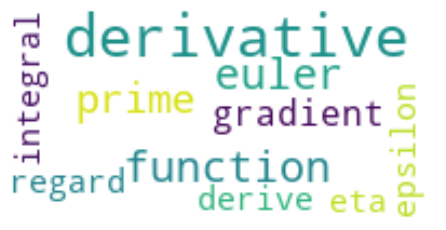

Topic 3


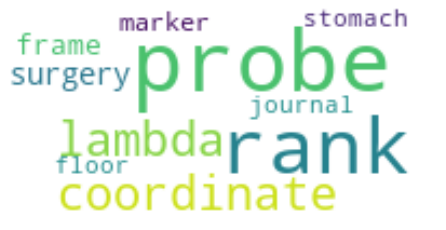

Topic 4


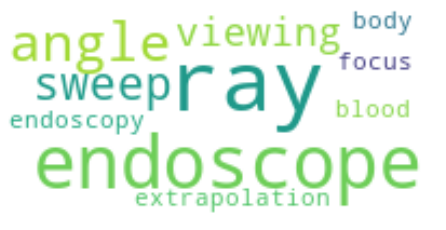

Topic 5


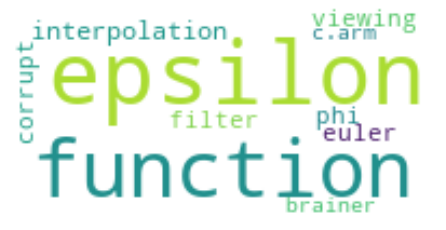

Topic 6


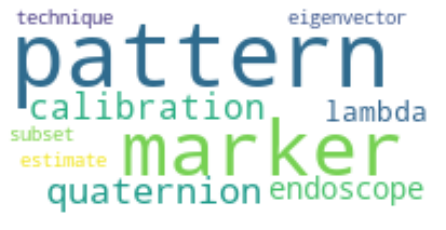

Topic 7


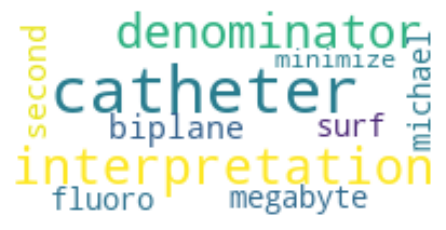

Topic 8


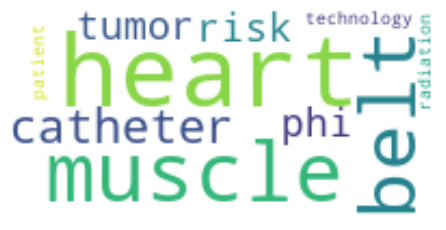

Topic 9


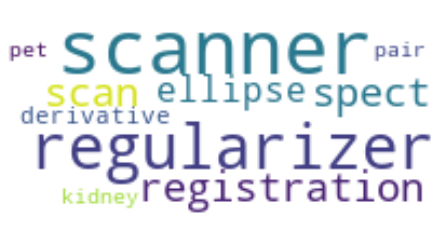

Topic 10


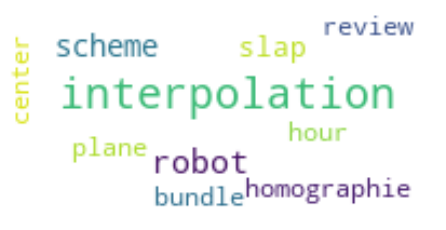

Topic 11


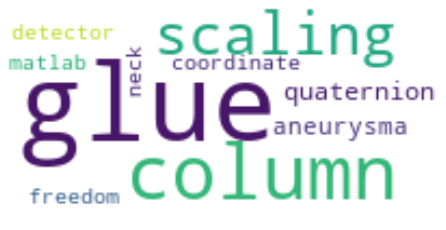

Topic 12


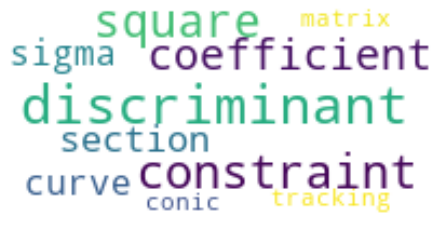

Topic 13


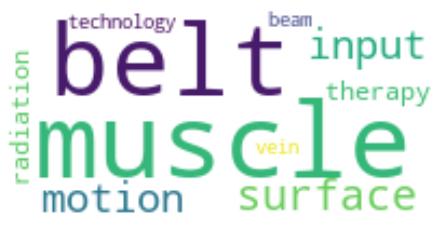

Topic 14


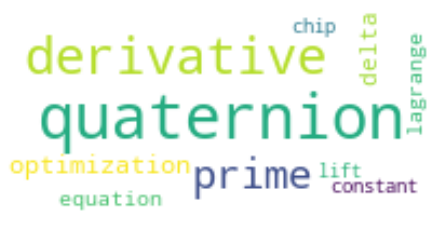

In [29]:
for i in range(best_model.num_topics):
    print("Topic %d" % i)
    try:
        topic_word_cloud(best_model,i,10)
    except OSError:
        continue

### Applying NMF to a new document

In [30]:
#create a new corpus, which contains all documents
#these are important for the tfidf vectors
new_corpus = [dataset.doc2bow(speech_df_test['Text_tokens'][0])]
total_corpus = new_corpus + used_corpus_nmf

#The tfidf vectorizer need to be added, otherwise the word-count would be wrong
tfidf_vect = TfidfModel(used_corpus_nmf)
#create the tfidf-vector of only the new corpus
tfidf = tfidf_vect[new_corpus]

#create a vector with the new model included
vector_nmf = best_model.get_document_topics(tfidf, normalize=None)

In [31]:
for topic in vector_nmf:
    print(topic)

[(2, 0.24209787200693467), (5, 0.05127653654220303), (6, 0.08652288321098167), (8, 0.09006497479772448), (9, 0.5195235077295709)]


In [32]:
def apply_dataframe_to_model(model,used_corpus,dataframe):
    new_corpus = [dataset.doc2bow(dataframe['Text_tokens'])]
    #we use a tfidf vectorizer based on the corpus for the training model
    tfidf_vectorizer = TfidfModel(used_corpus)
    tfidf_vector= tfidf_vectorizer[new_corpus]
    return model[tfidf_vector]

# Segmentation

The following sections splits the lectures into different parts, based on segement sizes in seconds

In [33]:
#this methods calcules the time, for each part
def getParts(maxDuration,segment_sec = 90, overlap = 30):
    start_at_every_time = segment_sec - overlap
    cur_time= 0
    counter = 0
    timesegments = []
    while cur_time < maxDuration:
        end_time = cur_time + segment_sec if (cur_time+segment_sec <= maxDuration) else maxDuration
        timesegments.append({"counter":counter,"start":cur_time,"end":end_time})
        cur_time += start_at_every_time
        counter += 1
    return timesegments


#we take the data out of the "speech_df_single_merged"
#there are all the lectures in parts with a timestamp from start to end(of each part)
def segment_lecture_to_dataframe(lecture_name,segment_sec=90,overlap=30,dataframe = speech_df_single_merged):
    #get a dataframe of only the requested lecture
    lecture_df = dataframe.loc[dataframe['File_name']==lecture_name]
    lecture_length = lecture_df["Time_to"].max()
    parts_time = getParts(lecture_length,segment_sec=segment_sec,overlap=overlap)
    segments = []
    for part in parts_time:
        data = getRowforSegment(lecture_df,part)
        if data:
            segments.append(data)
    return pd.DataFrame(segments)
    

#get the tokens for a given timeframe
def getRowforSegment(dataframe,segment):
    #get the rows in the timeframe as an dataframe
    df = dataframe.loc[dataframe['Time_to'] >= segment['start']]
    df = df.loc[df['Time_to'] <= segment['end']]
    if len(df)== 0:
        return
    #create a list with the all tokens
    combined_tokens = []
    for token_list in df['Text_tokens']:
        combined_tokens += token_list
    #return the result while combining the metadata
    return {'Lecture':df['Lecture'].iloc[0],
            'Time_from':df['Time_from'].min(),
            'Time_to':df['Time_to'].max(),
            'Text':' '.join(df['Text']),
            'Text_tokens':combined_tokens}

In [34]:
segment_lecture_to_dataframe("Hornegger-IMIP01",overlap=0)

""


# Pipeline

The following part creates a pipeline with all the previous methods

1. Create a dataframe with all lectures, including metadata like timestamps

In [35]:
#we collect all files now
# in the beginning of the notebook we used only the IMIP Lectures
files = []
for r,d,f in os.walk(path):
    for file in f:
        files.append(os.path.join(r,file).replace("\\","/"))
files.remove('LMELectures/trl/foreignwords.lex')


#create an dataframe with each lecture
speech_df_all_lectures = pd.DataFrame(columns=column_list)
for i in range(len(files)):
    f = open(files[i],"r")
    print(f)
    df = pd.DataFrame(convert_doc_to_dataframe(f))
    df['File_name']= files[i].replace(".wav",'').replace(path+'/','').replace(".trl",'')
    speech_df_all_lectures = speech_df_all_lectures.append(df)

<_io.TextIOWrapper name='LMELectures/trl/20090427-Hornegger-IMIP01.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090427-Hornegger-PA01.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090428-Hornegger-IMIP02.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090428-Hornegger-PA02.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090504-Hornegger-IMIP03.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090504-Hornegger-PA03.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090505-Hornegger-PA04.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090511-Hornegger-IMIP05.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090511-Hornegger-PA05.trl' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='LMELectures/trl/20090512-Hornegger-IMIP06.trl' mode='r' encoding='cp1252'>
<_io.TextI

In [36]:
speech_df_all_lectures.head()

,Lecture,Date,Time_from,Time_to,Text,Text_tokens,File_name
0,Hornegger-IMIP01,20090427,1.48,3.23,so welcome to the,[welcome],20090427-Hornegger-IMIP01
1,Hornegger-IMIP01,20090427,4.36,25.30,first lecture on interventional image process...,"[lecture, image, processing, winter, semester,...",20090427-Hornegger-IMIP01
2,Hornegger-IMIP01,20090427,25.96,35.55,the summer semester and i think eva gave a ve...,"[summer, semester, think, introduction, week, ...",20090427-Hornegger-IMIP01
3,Hornegger-IMIP01,20090427,36.24,52.98,and intervention is a completely different ca...,"[intervention, category, diagnostic, intervent...",20090427-Hornegger-IMIP01
4,Hornegger-IMIP01,20090427,53.48,62.85,so you always have to keep the picture in min...,"[picture, mind, patient, blood, equipment, mon...",20090427-Hornegger-IMIP01


2. We create a dataframe for segmentation. Each lecture is one row of the dataframe

In [37]:
docs = []
for i in range(len(files)):
    file = open(files[i], "r")
    tokens,texts = convert_lecture_to_tokens(file)
    data = {'File_name':files[i].replace(".wav",'').replace(path+'/','').replace(".trl",''),
            'Text_tokens':tokens, 
            'Text':filter_special_tokens(texts).replace("\n","")}
    docs.append(data)
        
speech_df_all_lectures_train = pd.DataFrame(docs)

In [38]:
speech_df_all_lectures_train.head()

,File_name,Text_tokens,Text
0,20090427-Hornegger-IMIP01,"[welcome, lecture, image, processing, winter, ...",so welcome to the first lecture on interventi...
1,20090427-Hornegger-PA01,"[start, start, recording, tomorrow, repeat, co...",okay so nice to have you here so we can start...
2,20090428-Hornegger-IMIP02,"[miss, professor, want, tone, pay, tell, minut...",i'm sorry i missed that confused professor if...
3,20090428-Hornegger-PA02,"[tuesday, session, consider, beginning, topic,...",welcome the tuesday session yesterday we were...
4,20090504-Hornegger-IMIP03,"[look, know, screw, system, video, look, navig...",looks good i don't know something screwed the...


3. Prepare the model (create the dictionary with all words). This also need to be re-done, since until this point we only used the IMIP-lectures

In [39]:
dataset = corpora.Dictionary()
dataset.add_documents(speech_df['Text_tokens'].tolist())

4. Create the pipeline  
* get the dataframe with only the used lecture
* get the training dataframe with all the other lectures of the same topic\
* create LSI-models with different topic nums (get the best of these)
* create NMF-models with different topic nums (get the best of these)
* dump the topics and keywords into a file( for each model type)
* apply different segmentations and save the topic distribution of these
* dump the distributions in files

In [50]:
def create_segmented_distribution(lecture_name):
    #get a dataframe (not segemented yet) for the lecture
    df_lecture = speech_df_all_lectures_train.loc[speech_df_all_lectures_train["File_name"]==lecture_name]
    
    #get the training dataframe
    #this consits of all lectures of the same topic except the lecture we analyse
    df_train = speech_df_all_lectures_train.loc[speech_df_all_lectures_train['File_name'] != lecture_name]
    if "PA" in lecture_name:
        df_train = df_train.loc[df_train['File_name'].str.contains('PA')]
    elif "IMIP" in lecture_name:
        df_train = df_train[df_train['File_name'].str.contains('IMIP')]

    #create LSI models
    #corpus is created inside the evaluate function
    model_list_lsi, coherence_values_lsi , lsi_corpus = evaluate_graph(df_train,min_topic_num=4,max_topic_num=14,model_type="lsi")
    # get the best lsi model
    index_value = coherence_values_lsi.index(max(coherence_values_lsi))
    best_lsi_model = model_list_lsi[index_value]
    #write model keywords to file
    write_model_to_file(model= best_lsi_model, filename='model_keywords/{0}_lsi_keywords'.format(lecture_name))
    
    
    # create NMF models
    model_list_nmf, coherence_values_nmf , nmf_corpus = evaluate_graph(df_train,min_topic_num=4,max_topic_num=14,model_type="nmf")
    # get the best nmf model
    index_value = coherence_values_nmf.index(max(coherence_values_nmf))
    best_nmf_model = model_list_nmf[index_value]
    #write model keywords to file
    write_model_to_file(model= best_nmf_model, filename='model_keywords/{0}_nmf_keywords'.format(lecture_name))
    
    #define the times in which the document should be segmented
    #the first value represents the segment size and the second the overlap
    timestamps = [(60,0),
                  (90,0),
                  (120,0),
                  (60,30),
                  (90,30),
                  (120,30)]
    
    
    for time in timestamps:
        distrib_lsi = []
        distrib_nmf = []
        #create the dataframe with the segments according to the timestamps 
        df_segmented = segment_lecture_to_dataframe(lecture_name=lecture_name,
                                                   segment_sec= time[0],
                                                   overlap = time[1],
                                                   dataframe = speech_df_all_lectures)
        
        #calculate the topic distribution for each segment of the lecture
        #the calcualation is done with the lsi and the nmf model
        for i in range(len(df_segmented)):
            topic_dist_lsi = get_distrib_as_dict(model=best_lsi_model,
                                                 used_corpus= lsi_corpus,
                                                 dataframe=df_segmented.iloc[i],
                                                 normalize=True)
            
            topic_dist_nmf = get_distrib_as_dict(model=best_nmf_model,
                                                 used_corpus= nmf_corpus,
                                                 dataframe=df_segmented.iloc[i])
            
            distrib_lsi.append({"Time_from":df_segmented.loc[i,"Time_from"],
                                "Time_to":df_segmented.loc[i,"Time_to"],
                                "Topic_dist":topic_dist_lsi})
            
            distrib_nmf.append({"Time_from":df_segmented.loc[i,"Time_from"],
                                "Time_to":df_segmented.loc[i,"Time_to"],
                                "Topic_dist":topic_dist_nmf})    
        #dump into file
        json.dump(distrib_lsi, open( 'model_distrib/{0}_lsi_{1}_{2}.json'.format(lecture_name,time[0],time[1]), 'w' ) )  
        json.dump(distrib_nmf, open( 'model_distrib/{0}_nmf_{1}_{2}.json'.format(lecture_name,time[0],time[1]), 'w' ) ) 
    

def get_distrib_as_dict(model,used_corpus,dataframe, normalize = False):
    vector = apply_dataframe_to_model(model=model,used_corpus=used_corpus,dataframe=dataframe)
    distribs = {}
    for dist in vector:
        distribs = dict((int(x),float(y))  for x,y in dist)
    if normalize:
        try:
            max_value = max(distribs.values())
            min_value = min(distribs.values())
            for key in distribs:
                distribs[key] = (distribs[key]-min_value)/(max_value-min_value)
        except:
            return
    return distribs

5. Loop through all files and create the different distributions

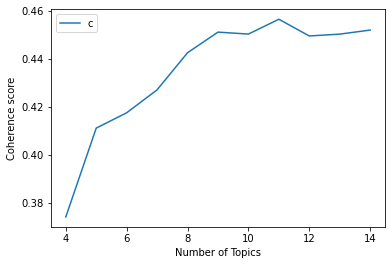

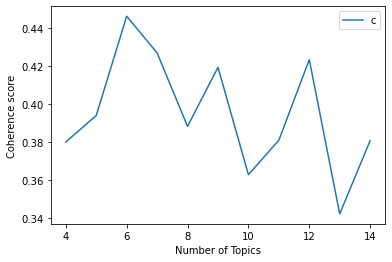

In [51]:
create_segmented_distribution('20090427-Hornegger-IMIP01')

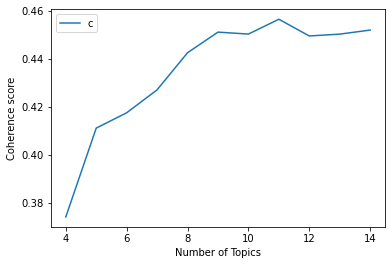

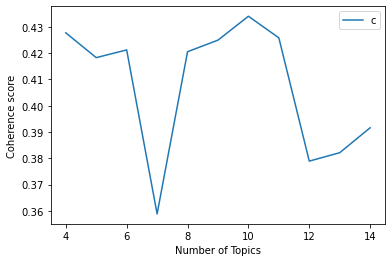

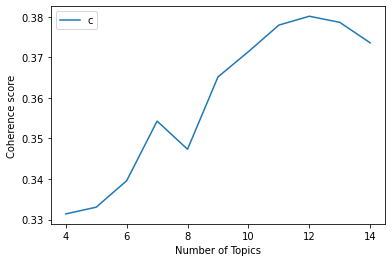

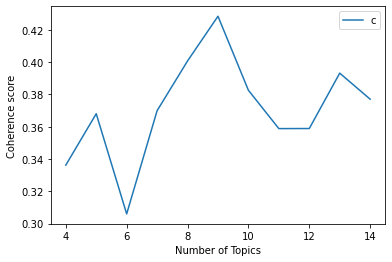

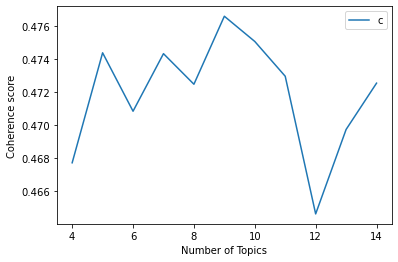

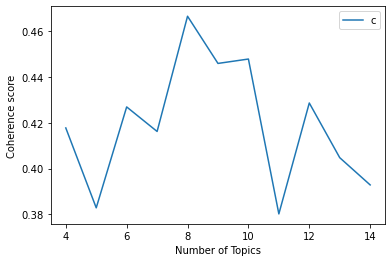

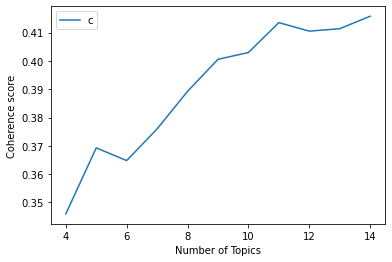

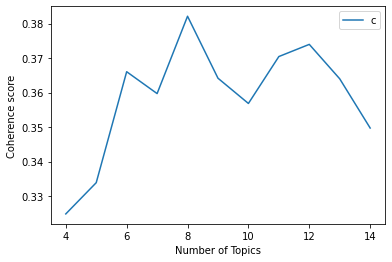

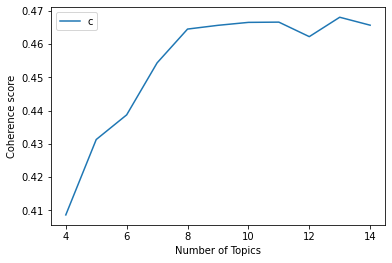

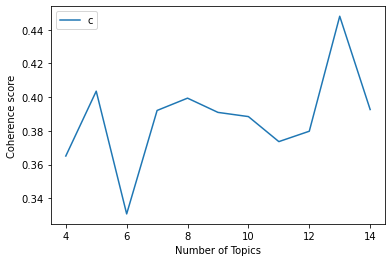

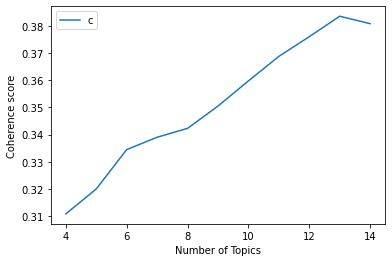

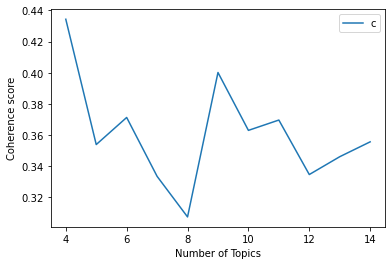

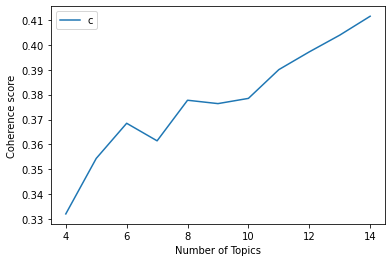

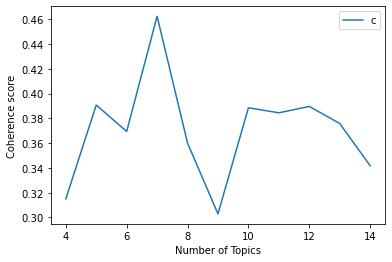

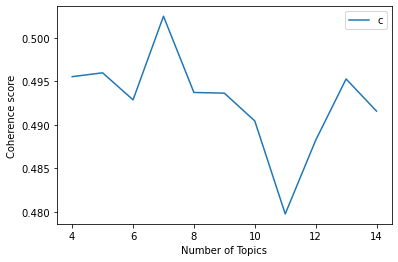

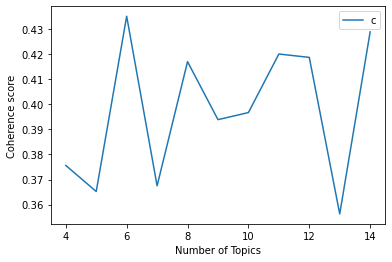

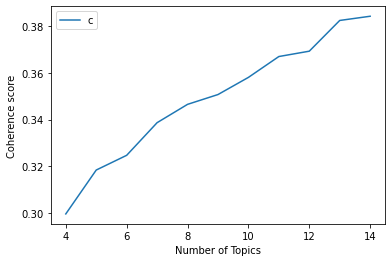

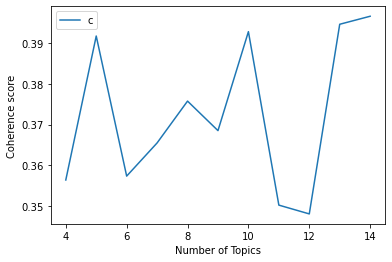

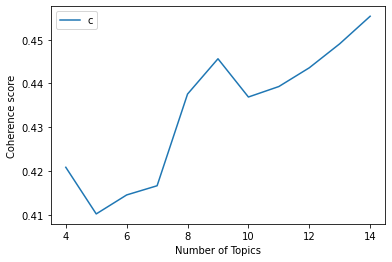

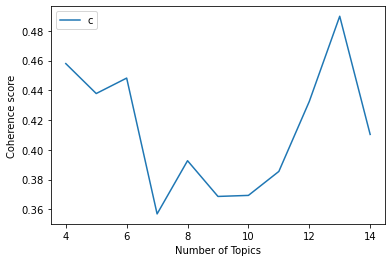

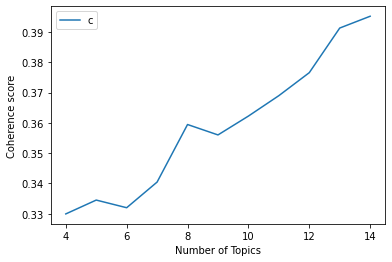

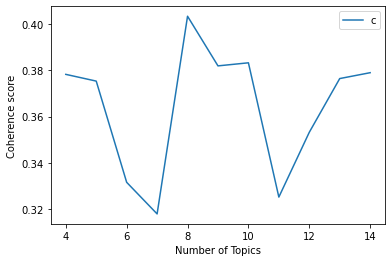

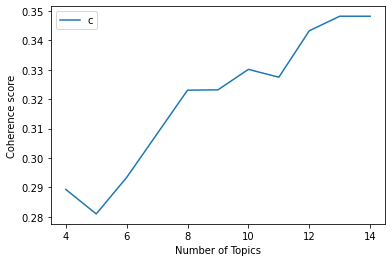

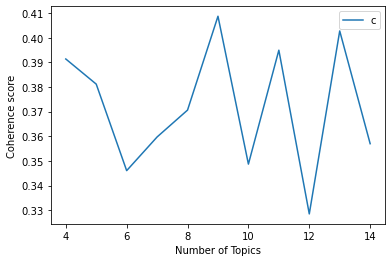

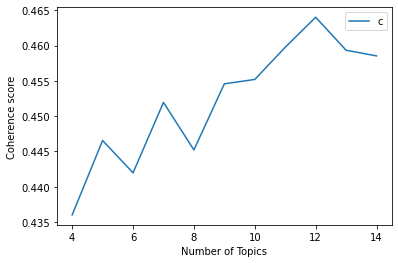

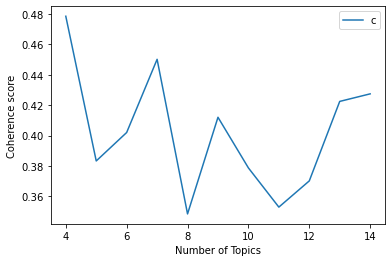

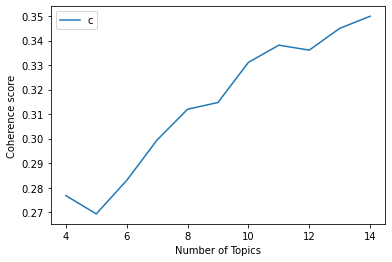

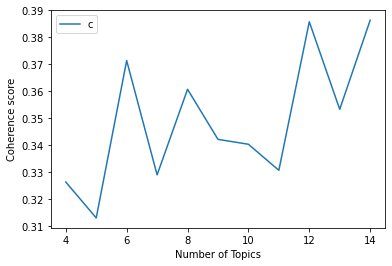

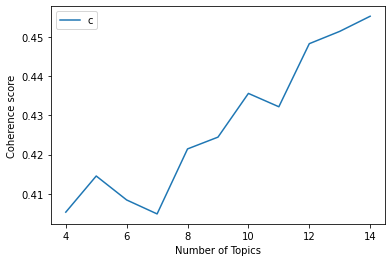

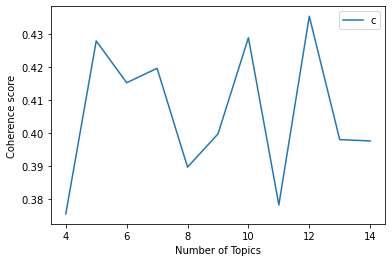

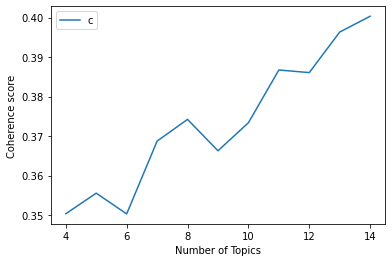

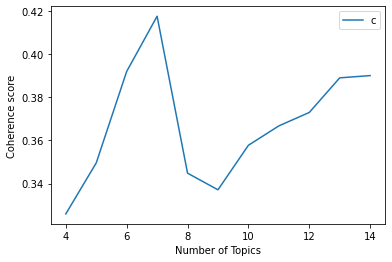

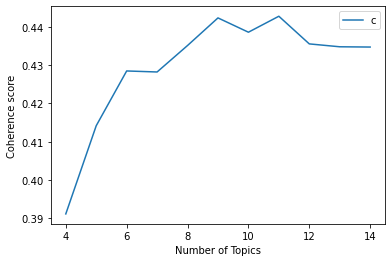

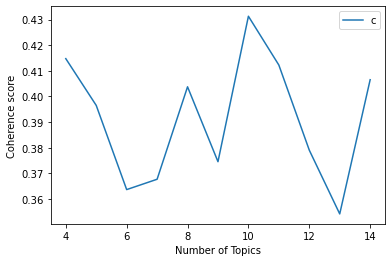

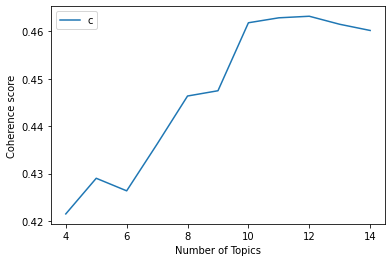

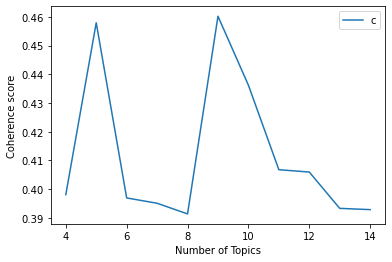

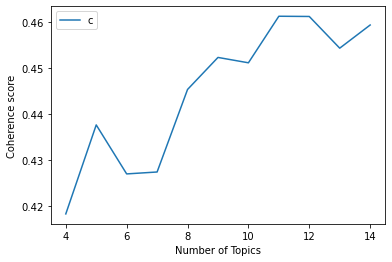

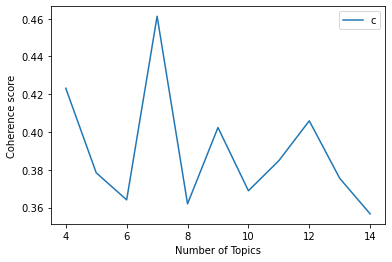

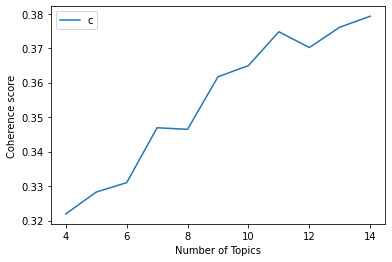

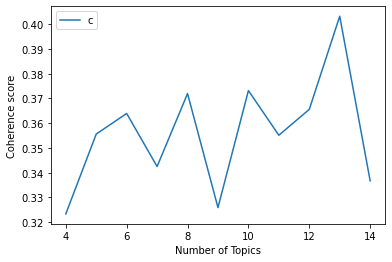

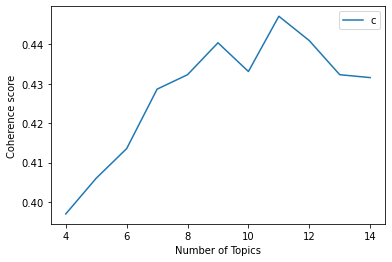

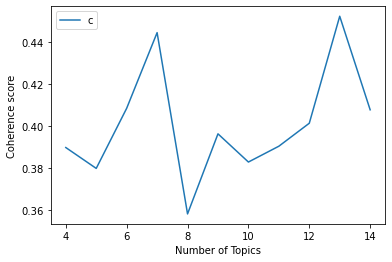

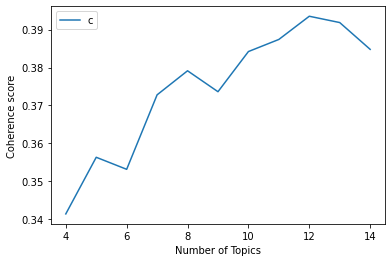

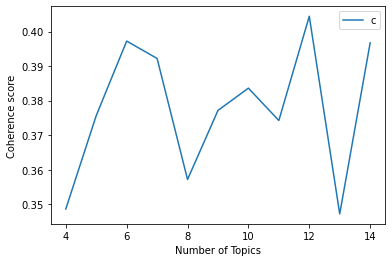

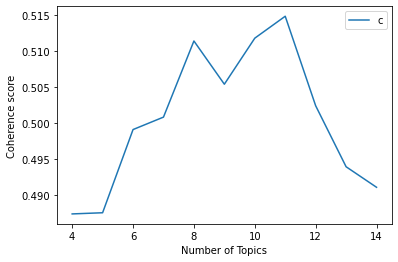

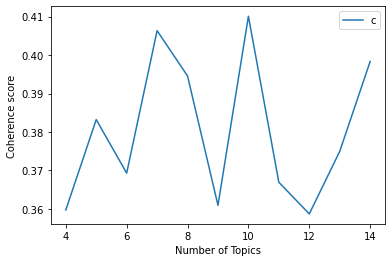

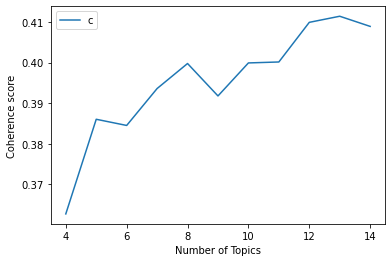

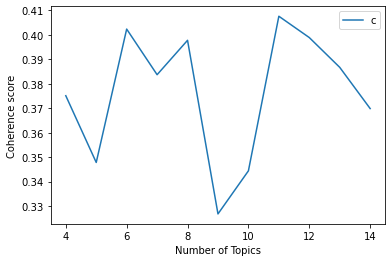

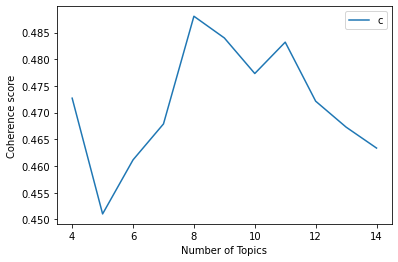

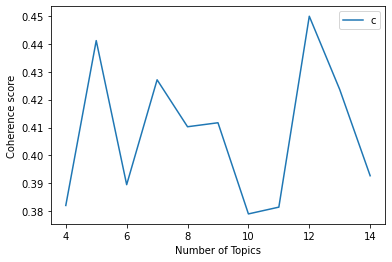

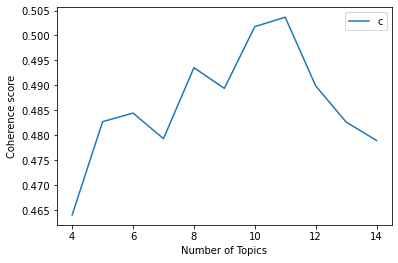

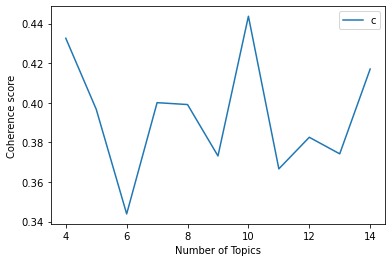

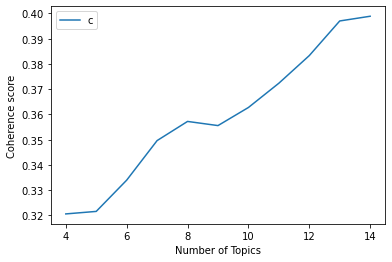

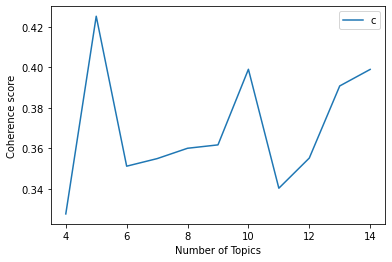

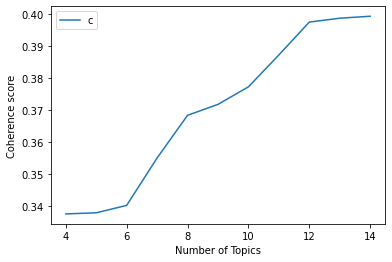

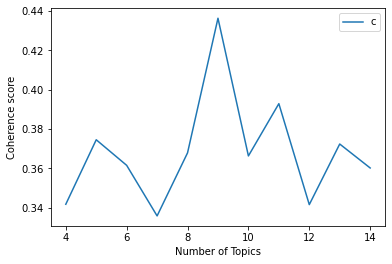

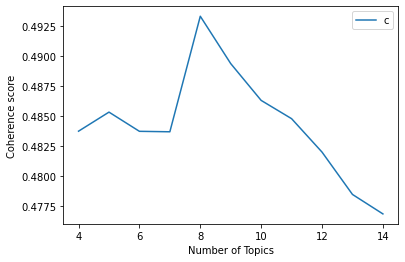

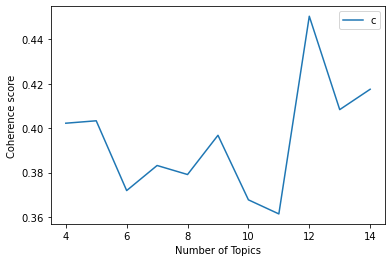

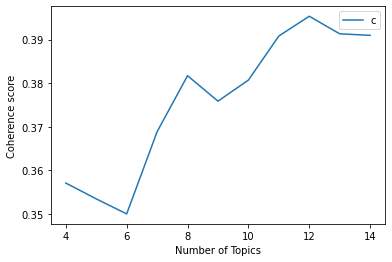

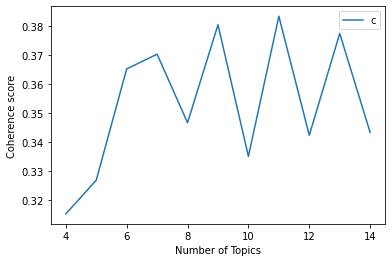

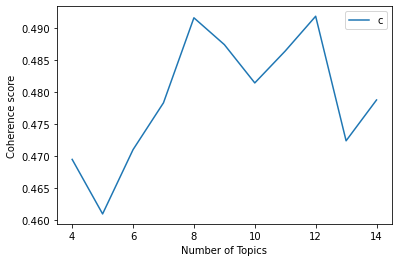

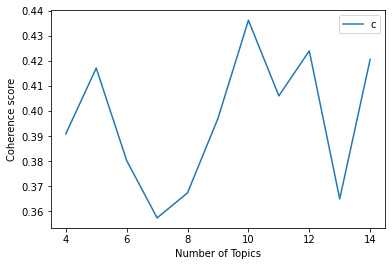

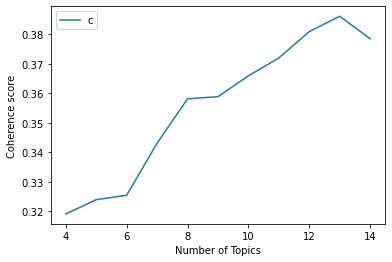

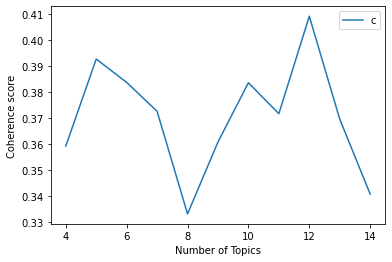

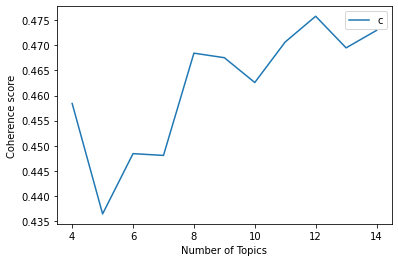

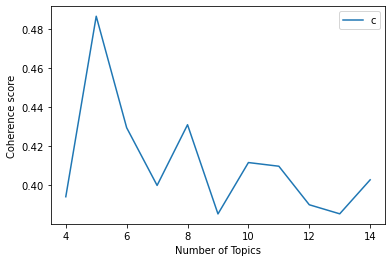

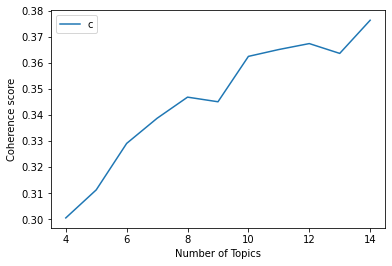

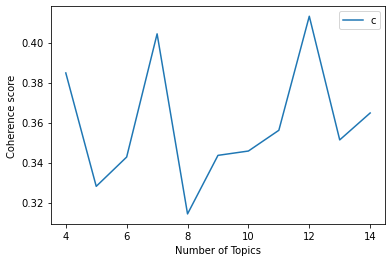

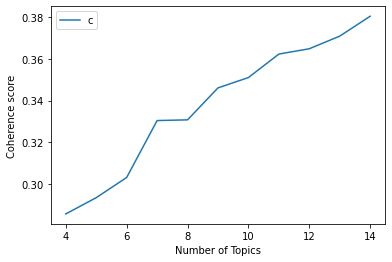

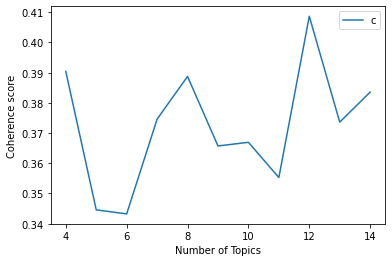

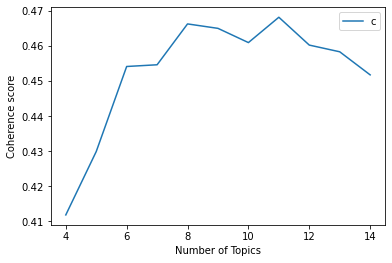

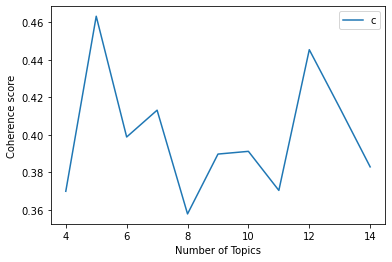

Wall time: 1h 26min 9s


In [52]:
%%time
for i in range(len(files)):
    create_segmented_distribution(files[i].replace(".wav",'').replace(path+'/','').replace(".trl",''))

# TopicTiling 

One algorithm for topic segmentation is 'TopicTiling'. We will use the Java implementation found under  
https://github.com/riedlma/topictiling  
  
It uses LDA for TopicModelling (GibbsLda). We only need to prepare the data for it in this notebook. The rest will be handeld in the terminal

This pre-processing contains of:  
* Reading the files -> we will use the 20 lines per 'document' like we used above
* Writing the files to a folder, in the required format

In [53]:
#write the training data to files 
def prepare_gibbslda():
    #get the training dataframes
    df_train_pa   = speech_df_all_lectures_train.loc[ speech_df_all_lectures_train['File_name'].str.contains('PA')]
    df_train_imip = speech_df_all_lectures_train.loc[ speech_df_all_lectures_train['File_name'].str.contains('IMIP')]
    
    #the model by gibbslda is safed in the same folder as the trainingsdata
    #so we create a folder for each lecture
    path_folder = 'gibbslda_training_documents/{0}'
    Path(path_folder.format('IMIP')).mkdir(parents=True, exist_ok=True)
    Path(path_folder.format('PA')).mkdir(parents=True, exist_ok=True)
    
    #write the IMIP tokens
    f = open('gibbslda_training_documents/IMIP/training_data.txt'.format(path_folder), 'w') 
    f.write(str(len(df_train_imip)) + '\n')
    for tokens in df_train_pa['Text_tokens']:
        text = ' '.join(tokens) + '\n'
        f.write(text)
    f.close()
    
    #write the PA tokens
    f = open('gibbslda_training_documents/PA/training_data.txt'.format(path_folder), 'w') 
    f.write(str(len(df_train_pa)) + '\n')
    for tokens in df_train_imip['Text_tokens']:
        text = ' '.join(tokens) + '\n'
        f.write(text)
    f.close()

In [54]:
#test function above
prepare_gibbslda()

We dont have a dataframe where each lecture represents 1 row (the speech_df only contains the IMIP lecture). So we first create a new dataframe and the create the files which needs to be segmented

In [55]:
docs = []
for i in range(len(files)):
    file = open(files[i], "r")
    tokens,texts = convert_lecture_to_tokens(file)
    data = {'File_name':files[i].replace(".wav",'').replace(path+'/','').replace(".trl",''),
            'Text_tokens':tokens, 
            'Text':filter_special_tokens(texts).replace("\n","")}
    docs.append(data)
speech_df = pd.DataFrame(docs)

In [56]:
#write the tokens of one lecture into files
def prepare_topictiling(lecture_name):
    lecture_df = speech_df_all_lectures.loc[speech_df_all_lectures["File_name"] == lecture_name]
    #get the tokens as a list of list
    tokens_tmp= lecture_df['Text_tokens'].tolist()
    
    #TopicTiling needs sentences, and since the original data has no punctuation,
    #so we add a dot after every line of the og data
    tokens = []
    for token in tokens_tmp:
        for tok in token:
            tokens.append(tok)
        tokens.append('.')

    #convert list to string
    tokens = ' '.join(tokens)
    #remove space beetween word and the following punctation
    tokens = tokens.replace(' .','.')
    
    lecture_key= "IMIP" if "IMIP" in lecture_name else "PA"
    #the model by gibbslda is safed in the same folder as the trainingsdata
    #so we create a folder for each lecture
    path_folder = 'topictiling_documents/{0}/{1}'.format(lecture_key,lecture_name)
    Path(path_folder).mkdir(parents=True, exist_ok=True)
    
    f = open('{0}/tokens.txt'.format(path_folder), 'w')  
    f.write(tokens)
    
    f.close()

In [57]:
#test function above
prepare_topictiling('20090427-Hornegger-IMIP01')

In [58]:
prepare_topictiling('20090512-Hornegger-PA06')

In [59]:
#loop through each lecture and create the files and TopicTiling
for i in range(len(files)):
    file = files[i].replace(".wav",'').replace(path+'/','').replace(".trl",'')
    prepare_topictiling(file)

# Test of Python_Flask_app

This part can test the Flask App, since all the lectures can be read with methods from here, and send via REST to the endpoints

In [ ]:
import requests

#this methods add all lectures to the database via the flask endpoint(running inside docker)
#the last lecture of each topic is added seperately, because they trigger calculating a new model. We dont want to do this
# for every lecture, because it would be timeconsuming and useless because it gets overwritten everytime

path  = 'LMELectures/trl'
files = []
for r,d,f in os.walk(path):
    for file in f:
        files.append(os.path.join(r,file).replace("\\","/"))
files.remove('LMELectures/trl/foreignwords.lex')
#remove the last lecture of each course
files.remove('LMELectures/trl/20090721-Hornegger-IMIP23.trl')
files.remove('LMELectures/trl/20090720-Hornegger-PA22.trl')

#set the files to only the last lectures of the course
#this is used for creating the model
files=['LMELectures/trl/20090721-Hornegger-IMIP23.trl','LMELectures/trl/20090720-Hornegger-PA22.trl']

for i in range(len(files)):
    f = open(files[i],"r")
    lecture = files[i].replace(".wav",'').replace(path+'/','').replace(".trl",'')
    lecture_key = "IMIP" if "IMIP" in lecture else "PA"
    parts = []
    for row in f:
        if ".wav" in row:
            index = row.index(".wav")+4
            meta = row[:index]
            row = row[index:]
            _, _, time_from, time_to = extract_info_from_metadata(meta)
            parts.append({'time_from': time_from,'time_to': time_to, 'text': row})
    post_data = {'lecture':lecture,'lecture_key':lecture_key,
                 #the update=False part is for adding lectures without creating new models
                 #this is useful for inserting multiple lectures, but the last model mustn't have it
#                 'update':False,
                 'texts':parts}
    x = requests.post(url= 'http://localhost:5000/insert',json= post_data, timeout=None)
    print(x.text)

In [18]:
#this part checks if the keywords work
base_url = 'http://localhost:5000/keywords?lecture_key={0}&model_type={1}'
key_combs = ['IMIP', 'PA']
type_combs = ['nmf', 'lsi']
for x in range(len(key_combs)):
    for y in range(len(type_combs)):
        req = requests.get(url= base_url.format(key_combs[x],type_combs[y]))
        print('Keywords for key={0} and model={1}'.format(key_combs[x],type_combs[y]))
        print(req.text)

Keywords for key=IMIP and model=nmf
{
  "result": {
    "0": "density regularizer bone registration similarity log liver dependency knowledge displacement ", 
    "1": "histogram c.arm intensity heart error michael reconstruction second efficiency smoothing ", 
    "10": "ellipse multiplier square scaling scanner estimator lagrange pair solution motion ", 
    "11": "derivative euler registration gradient prime filter integral regularizer similarity intensity ", 
    "12": "pattern factorization perspective calibration model depth coordinate transformation eye subset ", 
    "13": "matrix product identity column ellipse line projection constraint component pattern ", 
    "14": "derivative function euler integral freedom constraint gradient ratio prime equation ", 
    "2": "camera heart motion reconstruction function lab liver window machine environment ", 
    "3": "regularizer column density registration scanner pattern unit similarity raphson topic ", 
    "4": "rank column matrix 

In [13]:
base_url= 'http://localhost:5000/topicdist?lecture={0}&model={1}&seg_sec={2}&overlap={3}'
test_lecture = '20090721-Hornegger-IMIP23'
type_combs = ['lsi','nmf']
seg_sec = 60
overlap = 0

for i in range(len(type_combs)):
    req = requests.get(url= base_url.format(test_lecture, type_combs[i], seg_sec , overlap))
    print('Topic Dist für {0}, model: {1}, seg_sec: {2}, overlap: {3}'.format(test_lecture, type_combs[i], seg_sec , overlap))
    print(req.text)

Topic Dist für 20090721-Hornegger-IMIP23, model: lsi, seg_sec: 60, overlap: 0
{
  "result": [
    {
      "distribution": {
        "0": 1.0, 
        "1": 0.9577921268307527, 
        "2": 0.0, 
        "3": 0.7782753674222889
      }, 
      "time_from": 4.62, 
      "time_to": 4.62
    }, 
    {
      "distribution": {
        "0": 1.0, 
        "1": 0.03313779594410889, 
        "2": 0.0, 
        "3": 0.7441481978504623
      }, 
      "time_from": 61.12, 
      "time_to": 61.12
    }, 
    {
      "distribution": {
        "0": 1.0, 
        "1": 0.7051964682461344, 
        "2": 0.0, 
        "3": 0.1671311402417808
      }, 
      "time_from": 120.13, 
      "time_to": 120.13
    }, 
    {
      "distribution": {
        "0": 0.9801832718728108, 
        "1": 1.0, 
        "2": 0.0, 
        "3": 0.8614406617816276
      }, 
      "time_from": 195.9, 
      "time_to": 195.9
    }, 
    {
      "distribution": {
        "0": 0.807313323408052, 
        "1": 1.0, 
        "2": 0.

# Examples  and experiments for the thesis

This parts contains examples for the thesis.

In [53]:
tokenize("first lecture on interventional image processing")
tokenize("today i'm going to talk about magnetic navigation")

['lecture', 'image', 'processing']

['talk', 'navigation']

## Experiment: Usage on biotechnology lectures

The following parts reads all the files from the bitechnology courses and adds them to the App, running in the docker environment.  
The cell needs to be executes twice, first with all lectures except the last one of each course and with the param 'update':False.  
The second time only with the last lectures and then the update param should be true

In [126]:
path  = 'horstir_transkripte'
files = []
for r,d,f in os.walk(path):
    for file in f:
        files.append(os.path.join(r,file).replace("\\","/"))

#remove the last lecture of each course
files.remove('horstir_transkripte/B14/Vorlesung11_EvolutionMutationMeiose_Tonspur.mp3.txt')
files.remove('horstir_transkripte/B19/Vorlesung10_MikrobioelleBiotechnologieSynthetischeBiologie_Tonspur.mp3.txt')
files.remove('horstir_transkripte/BVT/Vorlesung13_DownStreamProcessing_Tonspur.mp3.txt')
files.remove('horstir_transkripte/Mikrobiologie/Vorlesung13_Symbiose_Tonspur.mp3.txt')


files = ['horstir_transkripte/Mikrobiologie/Vorlesung13_Symbiose_Tonspur.mp3.txt',
          'horstir_transkripte/BVT/Vorlesung13_DownStreamProcessing_Tonspur.mp3.txt',
          'horstir_transkripte/B19/Vorlesung10_MikrobioelleBiotechnologieSynthetischeBiologie_Tonspur.mp3.txt',
          'horstir_transkripte/B14/Vorlesung11_EvolutionMutationMeiose_Tonspur.mp3.txt']

for i in range(len(files)):
    f = open(files[i],"r", encoding='UTF-8')
    regex = r"horstir_transkripte/(.*)/(.*)"
    parts = re.search(regex, files[i])
    lecture_key = parts.groups()[0]
    lecture = parts.groups()[1].replace('.mp3','').replace('Vorlesung','').replace('.txt','' )
    parts_lec = []
    time_from_old = 0
    for row in f:
        text_row = row.replace('A:', '').replace('<UNK>','')
        regex_time = r"(.*) #(\d*):(\d*):(\d*)-(.*)"
        parts = re.search(regex_time,text_row)
        if not parts:
            continue
        time_to= (int(parts.groups()[1])*60*60) +(int(parts.groups()[2])*60)+int(parts.groups()[3])
        text = parts.groups()[0]
        parts_lec.append({'time_from': time_from_old,'time_to': time_to, 'text': text})
        time_from_old = time_to
    f.close()
    post_data = {'lecture':lecture,'lecture_key':lecture_key,
                #the update=False part is for adding lectures without creating new models
#               'update':False,
                'lang':'ger','texts':parts_lec}
    x = requests.post(url= 'http://localhost:5000/insert',json= post_data, timeout=None)
    print(x.text)     

"Lecture was added"

"Lecture was added"

"Lecture was added"

"Lecture was added"



In [127]:
#this part checks if the keywords work
base_url = 'http://localhost:5000/keywords?lecture_key={0}&model_type={1}'
key_combs = ['B14', 'B19','BVT','Mikrobiologie']
type_combs = ['nmf', 'lsi']
for x in range(len(key_combs)):
    for y in range(len(type_combs)):
        req = requests.get(url= base_url.format(key_combs[x],type_combs[y]))
        print('Keywords for key={0} and model={1}'.format(key_combs[x],type_combs[y]))
        print(req.text)

Keywords for key=B14 and model=nmf
{
  "result": {
    "0": "Chromosomen Protonen ATP Kernporen Schwesterchromatiden Ribosomen Virus Endoplasmatischen Reticulum Biotechnologie ", 
    "1": "Chromosomen Meiose Peptidoglycan Schwesterchromatiden Nachkomme Elektron Untereinheit Leitgewebe Individuum Kombination ", 
    "2": "St\u00e4rke H\u00e4moglobin Verkn\u00fcpfung Fetts\u00e4ure Polysaccharide Doppelschicht Zellulose Ionen Adenosin Umgebung ", 
    "3": "Zucker Moos Virus Metabolismus Cyanobakterien Krebs Vitamin System Sauerstoff Meerwasser ", 
    "4": "Autophagie Spinnenseide Stammzellen Mikrotubuli Antik\u00f6rper Lysosomen Zellteilung Organ Zellzyklus Phase "
  }
}

Keywords for key=B14 and model=lsi
{
  "result": {
    "0": "Chromosomen Schwesterchromatiden Meiose Nachkomme Kombination Individuum Evolution Mutation Crossing Allele ", 
    "1": "Protonen ATP Autophagie Spinnenseide Kernporen St\u00e4rke Membran Ribosomen Peptidoglycan Chromosomen ", 
    "2": "Protonen Spinnense

# Experiment: Detect borders of chained lectures

In [4]:
def convert_topictiling_dataframe(filename):
    root = ET.parse(filename).getroot()
    values = []
    for type_tag in root.findall('document/segments/segment'):
        depthScore = type_tag[0].text
        text = type_tag[1].text
        values.append({"tokens": text.replace("\n",""), "depthScore": float(depthScore)})
    return pd.DataFrame(values)

def plot_ttDataframe(dataframe,lecture_ends=[]):
    # Show graph
    x = range(len(dataframe))
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(x, dataframe['depthScore'])
    plt.xlabel("Segments")
    plt.ylabel("depthScores")
    plt.legend(("c"), loc='best')
    for point in lecture_ends:
        plt.axvline(x=point, color="red")
    plt.show()

In [5]:
tt_pa_df = convert_topictiling_dataframe("topictiling_documents/PA/Experiment-PA08-09-13-14/topictiling.txt")
tt_imip_df = convert_topictiling_dataframe("topictiling_documents/IMIP/Experiment-IMIP10-12-13-14/topictiling.txt" )

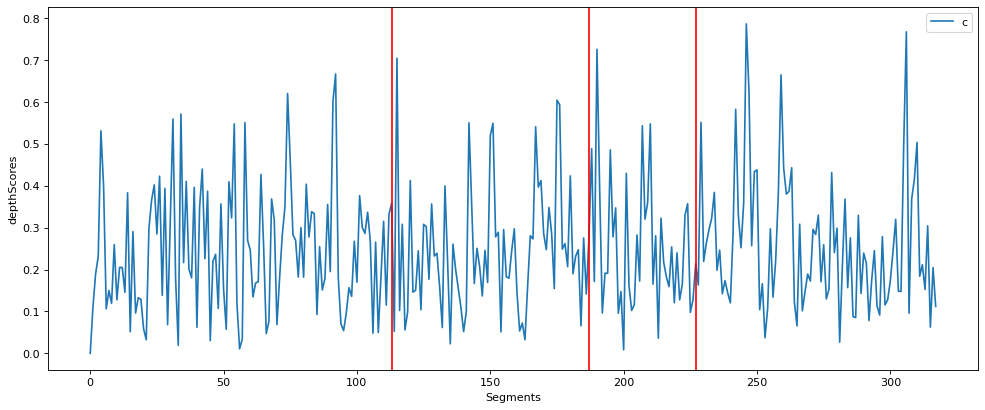

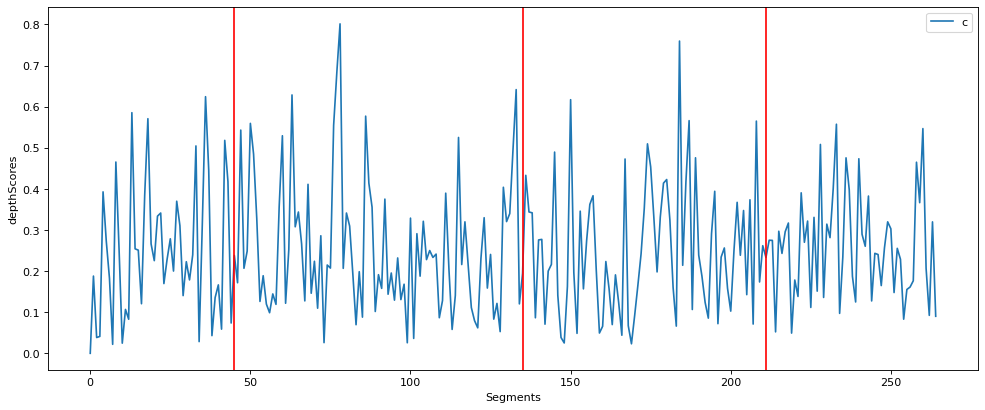

In [6]:
plot_ttDataframe(tt_imip_df, lecture_ends=[113,187,227])
plot_ttDataframe(tt_pa_df, lecture_ends=[45,135,211])